In [1]:
import tensorboard

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
from keras.callbacks import TensorBoard
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import src.data.Dataset as dt

In [3]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [4]:
IMAGES_DATASET_PATH = os.path.abspath("./data/processed/original")
CSV_DATASET_PATH = os.path.abspath(
    "./data/processed/original/28560Images_detection.csv"
)

print(f"IMAGES_DATASET_PATH: {IMAGES_DATASET_PATH}")
print(f"CSV_DATASET_PATH:    {CSV_DATASET_PATH}")

IMAGES_DATASET_PATH: /Users/carlos/WORKSPACE/MegaClassifier/data/processed/original
CSV_DATASET_PATH:    /Users/carlos/WORKSPACE/MegaClassifier/data/processed/original/28560Images_detection.csv


In [5]:
dataset = dt.load_from_csv(CSV_DATASET_PATH)
dataset.head()

The file /Users/carlos/WORKSPACE/MegaClassifier/data/processed/original/28560Images_detection.csv has been successfully opened.


,file_name,label,binary_label,detector_label,subset
0,cervidae/cervidredorfallowdeer_zoo_1_4/20_2020...,cervidae,1,1,train
1,leporido/conejo_wellingtoncameratraps_ss/19081...,leporido,1,1,train
2,vacia/empty_snapshotmountainzebra/mtz_s1_d07_r...,vacia,0,1,train
3,vacia/noanimal_zoo_5_6_7_9/37_20210319_943_.jpg,vacia,0,1,test
4,vacia/empty_islandconservationcameratraps/domi...,vacia,0,1,train


In [6]:
dataset["file_name"] = dataset["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
dataset["binary_label"] = dataset["binary_label"].astype(str)

train_dataframe = dataset[dataset["subset"] == "train"]
validation_dataframe = dataset[dataset["subset"] == "validation"]
test_dataframe = dataset[dataset["subset"] == "test"]

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 25
VERSION = 1.0

train_datagen = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input
)
normal_datagen = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

validation_images = normal_datagen.flow_from_dataframe(
    dataframe=validation_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

test_images = normal_datagen.flow_from_dataframe(
    dataframe=test_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

Found 19991 validated image filenames belonging to 2 classes.
Found 4283 validated image filenames belonging to 2 classes.
Found 4286 validated image filenames belonging to 2 classes.


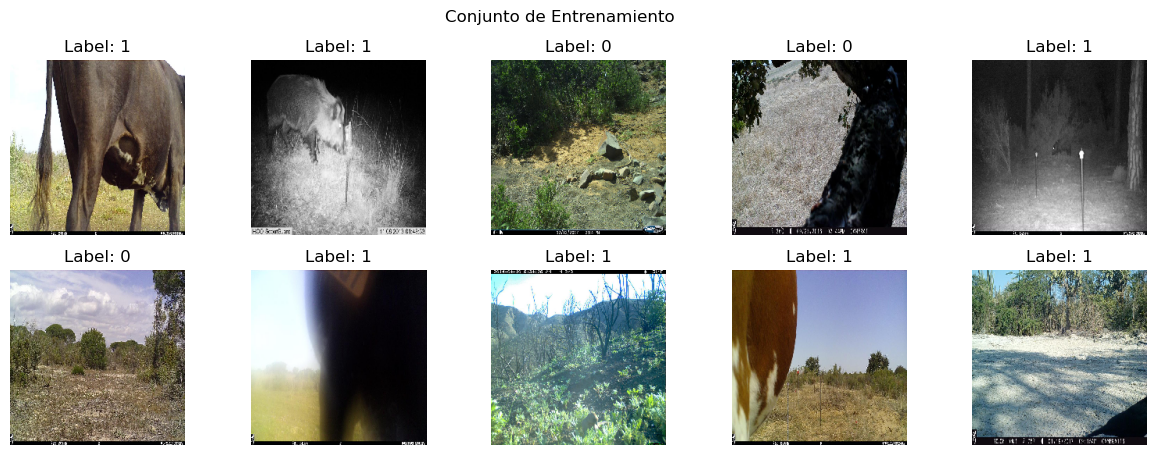

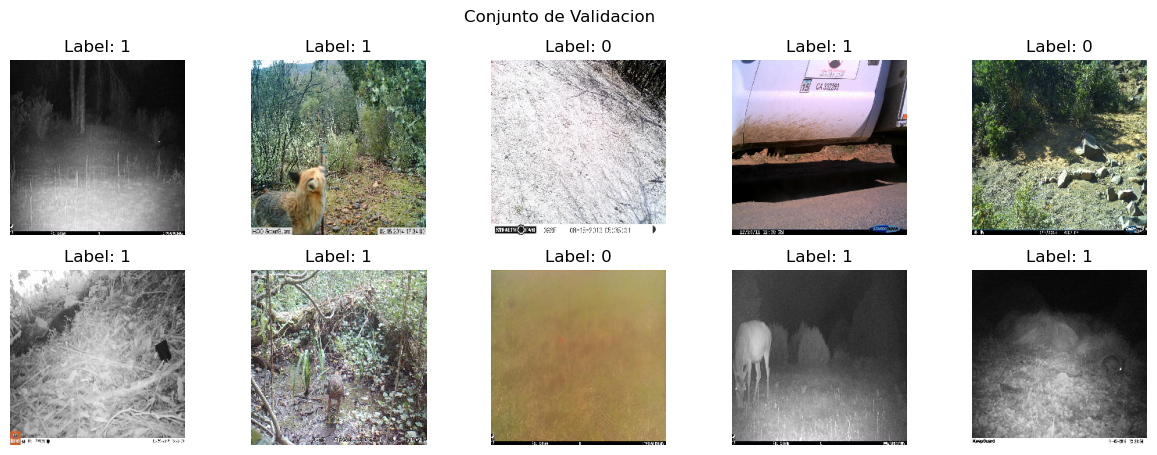

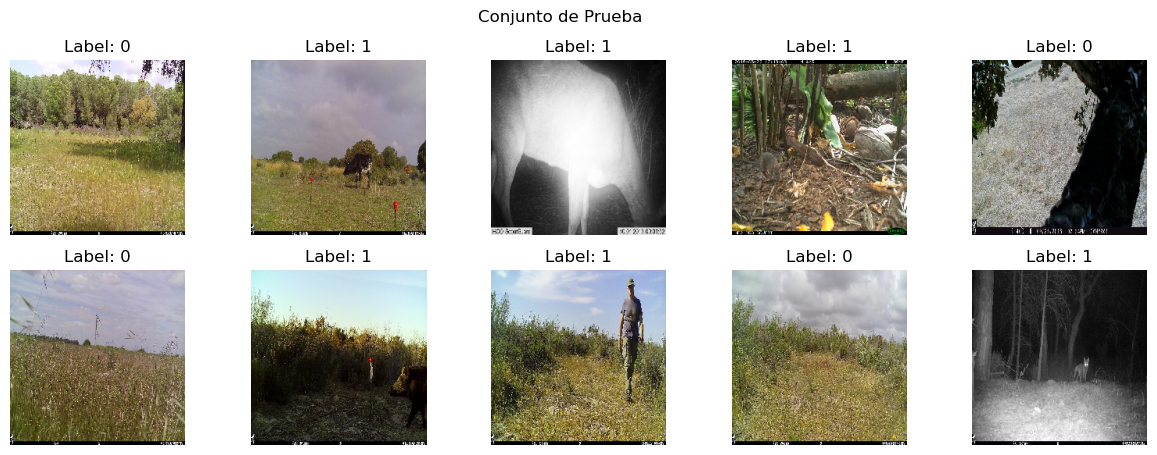

In [8]:
def show_random_images_from_generator(generator, title):
    images, labels = next(generator)
    # Asegúrate de que las imágenes estén en el rango [0, 1] para visualizarlas correctamente
    images = (
        images + 1
    ) * 127.5  # Si las imágenes están en el rango [-1, 1], esto las lleva a [0, 255]
    images = np.clip(images, 0, 255)  # Asegúrate de que no haya valores fuera de rango

    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(
            images[i].astype("uint8")
        )  # Convierte a enteros de 8 bits para la visualización
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


show_random_images_from_generator(train_images, "Conjunto de Entrenamiento")
show_random_images_from_generator(validation_images, "Conjunto de Validacion")
show_random_images_from_generator(test_images, "Conjunto de Prueba")

In [9]:
base_model = tensorflow.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False

model = tensorflow.keras.models.Sequential(
    [
        base_model,
        tensorflow.keras.layers.GlobalAveragePooling2D(),
        tensorflow.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name=f"MobileNetV2_v.{VERSION}",
)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc"),
        TruePositives(name="tp"),
        FalsePositives(name="fp"),
        TrueNegatives(name="tn"),
        FalseNegatives(name="fn"),
    ],
)

model.summary()

2024-12-26 10:07:29.388076: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-12-26 10:07:29.388115: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-26 10:07:29.388127: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-26 10:07:29.388167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-26 10:07:29.388186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "MobileNetV2_v.1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [10]:
history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=EPOCHS,
    callbacks=[TensorBoard(log_dir=f"./logs/MobileNetV2/v.{VERSION}")],
)

Epoch 1/25


2024-12-26 10:07:31.521990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.8561 - presision: 0.8863 - recall: 0.8978 - auc: 0.9295 - tp: 11874.0000 - fp: 1524.0000 - tn: 5241.0000 - fn: 1352.0000

2024-12-26 10:08:59.077539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 107s 338ms/step - loss: 0.3195 - accuracy: 0.8561 - presision: 0.8863 - recall: 0.8978 - auc: 0.9295 - tp: 11874.0000 - fp: 1524.0000 - tn: 5241.0000 - fn: 1352.0000 - val_loss: 0.2618 - val_accuracy: 0.8891 - val_presision: 0.9123 - val_recall: 0.9210 - val_auc: 0.9547 - val_tp: 2610.0000 - val_fp: 251.0000 - val_tn: 1198.0000 - val_fn: 224.0000
Epoch 2/25
313/313 [==============================] - 105s 334ms/step - loss: 0.2485 - accuracy: 0.8933 - presision: 0.9197 - recall: 0.9189 - auc: 0.9588 - tp: 12154.0000 - fp: 1061.0000 - tn: 5704.0000 - fn: 1072.0000 - val_loss: 0.2418 - val_accuracy: 0.8961 - val_presision: 0.9352 - val_recall: 0.9058 - val_auc: 0.9621 - val_tp: 2567.0000 - val_fp: 178.0000 - val_tn: 1271.0000 - val_fn: 267.0000
Epoch 3/25
313/313 [==============================] - 109s 347ms/step - loss: 0.2286 - accuracy: 0.9036 - presision: 0.9269 - recall: 0.9274 - auc: 0.9652 - tp: 12266.0000 - fp: 967.0000 - tn: 5798.0000 - 

In [11]:
model.save(f"./models/MobileNetV2/MobileNetV2_v.{VERSION}.h5")

/Users/carlos/miniconda3/envs/TFG/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
history_df = pd.DataFrame(history.history)
history_df.to_csv(
    f"./logs/MobileNetV2/v.{VERSION}/train_validation_history.csv", index=False
)

In [13]:
results = history.model.evaluate(test_images)
metric_names = history.model.metrics_names

evaluation_results = {
    ("test_" + name): value for name, value in zip(metric_names, results)
}
evaluation_df = pd.DataFrame([evaluation_results])
evaluation_df.to_csv(f"./logs/MobileNetV2/v.{VERSION}/test_history.csv", index=False)

67/67 [==============================] - 19s 288ms/step - loss: 0.2070 - accuracy: 0.9134 - presision: 0.9225 - recall: 0.9489 - auc: 0.9715 - tp: 2690.0000 - fp: 226.0000 - tn: 1225.0000 - fn: 145.0000
